In [2]:
!rm -r /content/__MACOSX

In [4]:
!mkdir /content/model

In [1]:
import zipfile

zip_path = '/content/Bone_Fracture_Binary_Classification.zip'  # path to your uploaded zip
extract_path = '/content/'  # destination folder

# Create the destination folder if it doesn't exist
import os
os.makedirs(extract_path, exist_ok=True)

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Extracted {zip_path} to {extract_path}")


Extracted /content/Bone_Fracture_Binary_Classification.zip to /content/


Found 9246 files belonging to 2 classes.
Found 829 files belonging to 2 classes.
Found 506 files belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Training Custom_CNN...

Epoch 1/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - accuracy: 0.7717 - loss: 1.0396 - val_accuracy: 0.8828 - val_loss: 0.6743
Epoch 2/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 35s 65ms/step - accuracy: 0.9482 - loss: 0.1945 - val_accuracy: 0.9356 - val_loss: 0.3076
Epoch 3/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - accuracy: 0.9820 - loss: 0.0687 - val_accuracy: 0.9749 - val_loss: 0.0752
Epoch 4/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - accuracy: 0.9864 - loss: 0.0537 - val_accuracy: 0.9641 - val_loss: 0.1854
Epoch 5/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - accuracy: 0.9894 - loss: 0.0320 - val_accuracy: 0.9746 - val_loss: 0.1247
Epoch 6/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.9932 - loss: 0.0334 - val_accuracy

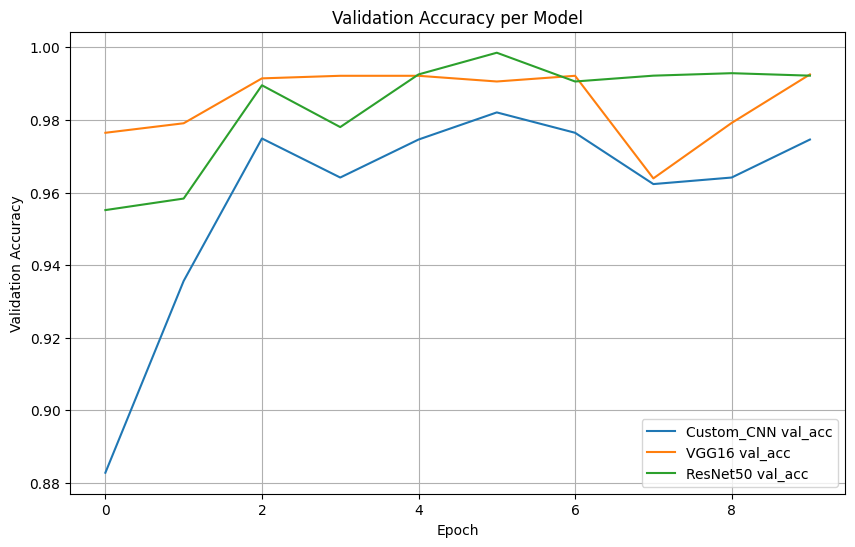

In [6]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, applications
import warnings
import os

warnings.filterwarnings('ignore')

data_train_path = "/content/Bone_Fracture_Binary_Classification/train"
data_test_path = "/content/Bone_Fracture_Binary_Classification/test"
data_val_path = "/content/Bone_Fracture_Binary_Classification/val"

img_width = 256
img_height = 256
batch_size = 32
epochs = 10

# Create output folder if it doesn't exist
os.makedirs("model", exist_ok=True)

# Load dataset function
def load_dataset(path):
    dataset = tf.keras.utils.image_dataset_from_directory(
        path,
        shuffle=True,
        image_size=(img_width, img_height),
        batch_size=batch_size
    )
    return dataset.apply(tf.data.experimental.ignore_errors())

# Load datasets
data_train = load_dataset(data_train_path)
data_val = load_dataset(data_val_path)
data_test = load_dataset(data_test_path)

AUTOTUNE = tf.data.AUTOTUNE
data_train = data_train.prefetch(buffer_size=AUTOTUNE)
data_val = data_val.prefetch(buffer_size=AUTOTUNE)
data_test = data_test.prefetch(buffer_size=AUTOTUNE)

# Custom CNN model
def build_custom_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(256,256,3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(2, activation='softmax')
    ])
    return model

# VGG16-based model
def build_vgg16():
    base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(2, activation='softmax')
    ])
    return model

# ResNet50-based model
def build_resnet50():
    base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(256,256,3))
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(2, activation='softmax')
    ])
    return model

# Training function
def train_model(model):
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(data_train,
                        validation_data=data_val,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=1)
    return history

# Model dictionary
models_dict = {
    "Custom_CNN": build_custom_cnn(),
    "VGG16": build_vgg16(),
    "ResNet50": build_resnet50()
}

histories = {}
val_accuracies = {}

# Train all models
for name, model in models_dict.items():
    print(f"\nTraining {name}...\n")
    history = train_model(model)
    histories[name] = history
    val_acc = history.history['val_accuracy'][-1]
    train_acc = history.history['accuracy'][-1]

    # Filter models with low overfitting/undercutting
    if abs(train_acc - val_acc) < 0.1:
        val_accuracies[name] = val_acc
    else:
        print(f"⚠️ Skipping {name} due to overfitting/undercutting (train: {train_acc:.2f}, val: {val_acc:.2f})")

# Select best model
best_model_name = max(val_accuracies, key=val_accuracies.get)
print(f"\n✅ Best model: {best_model_name} with val accuracy: {val_accuracies[best_model_name]:.2f}")
best_model = models_dict[best_model_name]

# Save best model
best_model.save("model/recognition_model.keras")
print("Model saved as model/recognition_model.keras")

# Evaluate on test set
test_loss, test_acc = best_model.evaluate(data_test, verbose=2)
print(f"\nTest accuracy of {best_model_name}: {test_acc * 100:.2f}%")

# Plot validation accuracy
plt.figure(figsize=(10,6))
for name, hist in histories.items():
    plt.plot(hist.history['val_accuracy'], label=f'{name} val_acc')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy per Model')
plt.legend()
plt.grid(True)
plt.show()